In [1]:
import pandas as pd
import numpy as np
import csv
from copy import deepcopy
from pandas import datetime
from copy import deepcopy
import gc
import random
import datetime
import csv
from copy import deepcopy
from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm_notebook
from Downloader import Extractor
from Preprocessing import Preprocessor, set_onelevel, set_multilevel
from Filters import XGBFilter
from Filters import quantile_huber_loss, quantile_huber_obj 
import pickle
import xgboost as xgb
import seaborn as sns
sns.set()
%matplotlib inline

/home/anna/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# getting file tree in directory "data_csv", which contains raw unfiltered data
mypath = './data_csv/Raw/'
dateparse = pd.to_datetime
station_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) if int(f.split('_', 1)[0])]
station_files.sort()

# reading loaded csv files from data_csv directory, output is a list (length=number of stations) of raw df 
raw_lmeteo_list = [pd.read_csv(mypath + '/' + station, index_col=0, 
                    dtype={'station_id': int,'date_time': str}, 
                    date_parser = dateparse, parse_dates = ['date_time']) 
                   for station in tqdm_notebook(station_files[:6])]

#fix problems with indexing, later this will be solved in loading part
for elem in raw_lmeteo_list:
    elem.reset_index(drop=True, inplace=True)

raw_data = pd.concat(raw_lmeteo_list)
raw_data['id'] = random.sample(range(len(raw_data)), len(raw_data))
raw_data['valid'] = True
raw_data = raw_data.reset_index(drop=True)

del raw_lmeteo_list
gc.collect()



Widget Javascript not detected.  It may not be installed or enabled properly.


42

In [3]:
%%time
preprocessor = Preprocessor()
meteo_splitted = preprocessor.PivotTable(raw_data)
# del raw_data

patterns_list = preprocessor.CreatePatternList(meteo_splitted)
# del pivoted_df

patterns_interpolated = preprocessor.InterpolatePatterns(patterns_list)
# del patterns_list

patterns_lagged = preprocessor.CreateLaggedTable(patterns_interpolated)
# del patterns_interpolated

final = pd.concat(patterns_lagged).reset_index(drop=True)

CPU times: user 1min 23s, sys: 276 ms, total: 1min 23s
Wall time: 1min 23s


In [4]:
final.columns

MultiIndex(levels=[['data_dampness', 'data_pressure', 'data_t_air', 'data_t_road', 'data_t_underroad', 'date_time', 'id_dampness', 'id_pressure', 'id_t_air', 'id_t_road', 'id_t_underroad', 'station_id', 'valid_dampness', 'valid_pressure', 'valid_t_air', 'valid_t_road', 'valid_t_underroad'], [-6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 11, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

from sklearn.decomposition import PCA

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# 
# X[0].columns

In [8]:
def params_analysis(pr, title, n_pca = 2):
    plt.close('all')
    print( "Analysis for", title)
    df = final[pr]
    scaler = StandardScaler().fit(df)
    X_scaled_pr = scaler.transform(df)
    
    pca_all = PCA()
    pca_all.fit(X_scaled_pr)
    pca = PCA(n_components= n_pca)
    X_pca_pr = pca.fit_transform(X_scaled_pr)
    
    f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(15,10))
        
    ax1.plot(pca_all.explained_variance_ratio_)
    ax1.set_title("PCA  explained variance ratio " + title) 

    
    ax2.scatter(X_pca_pr[:, 0], X_pca_pr[:, 1])
    ax2.set_title("PCA " + title)
        
    
    plt.show()

Analysis for Dampness


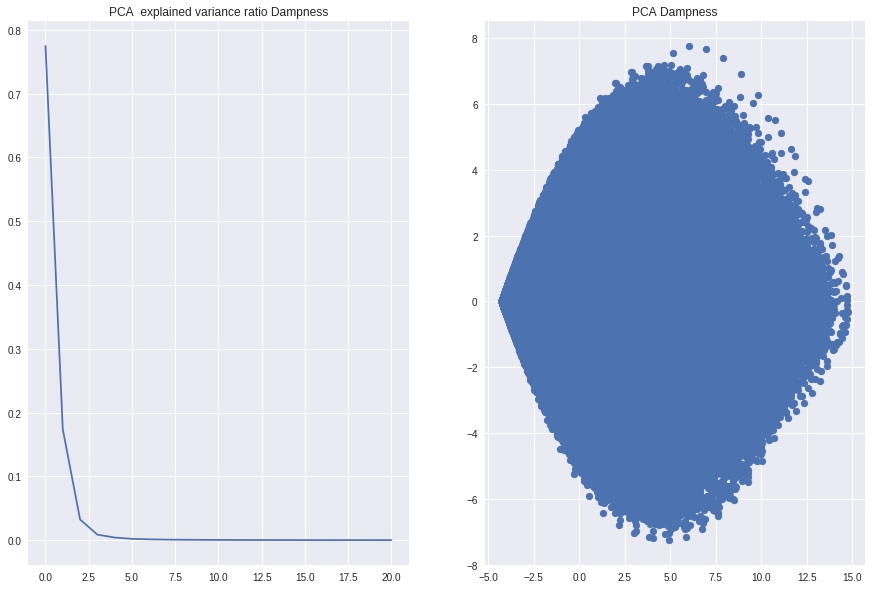

Analysis for Air temperature


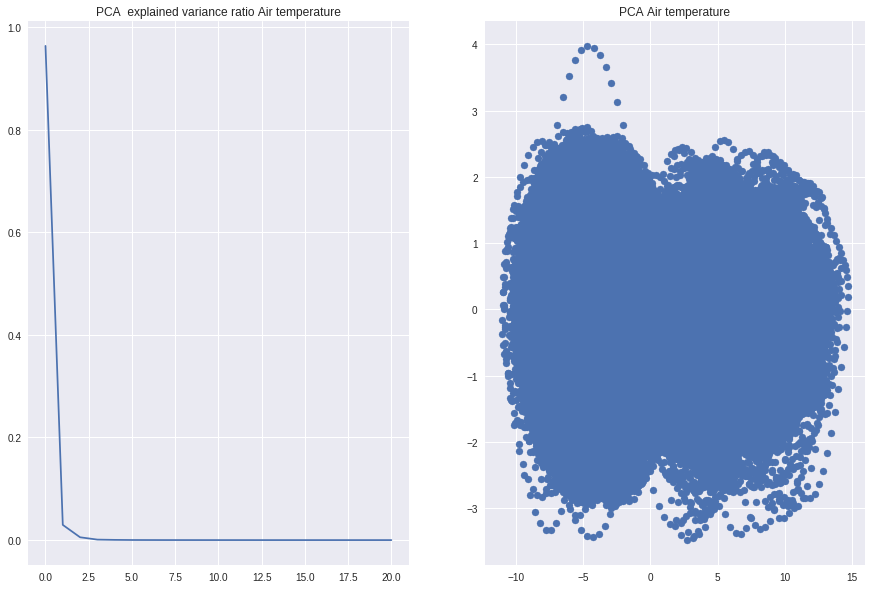

Analysis for Road temperature


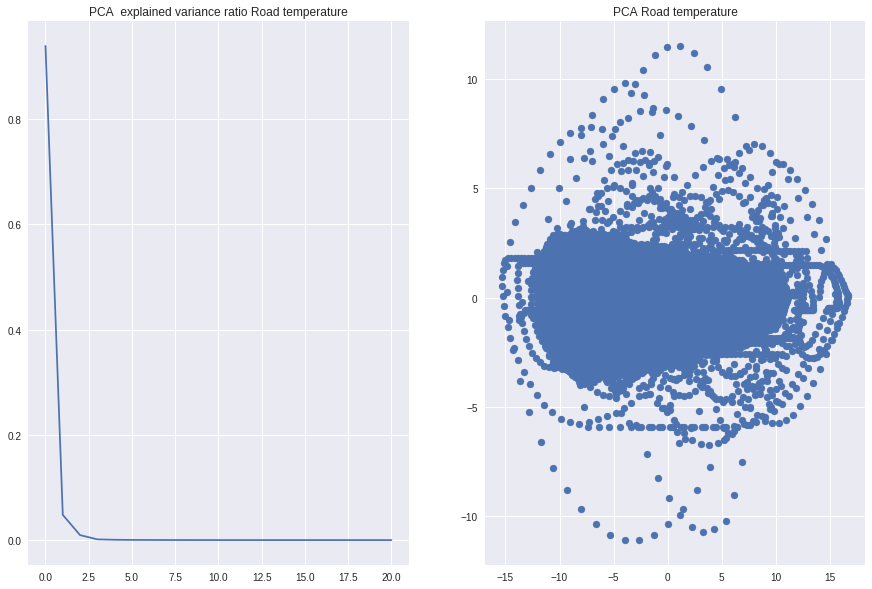

Analysis for Underroad temperature


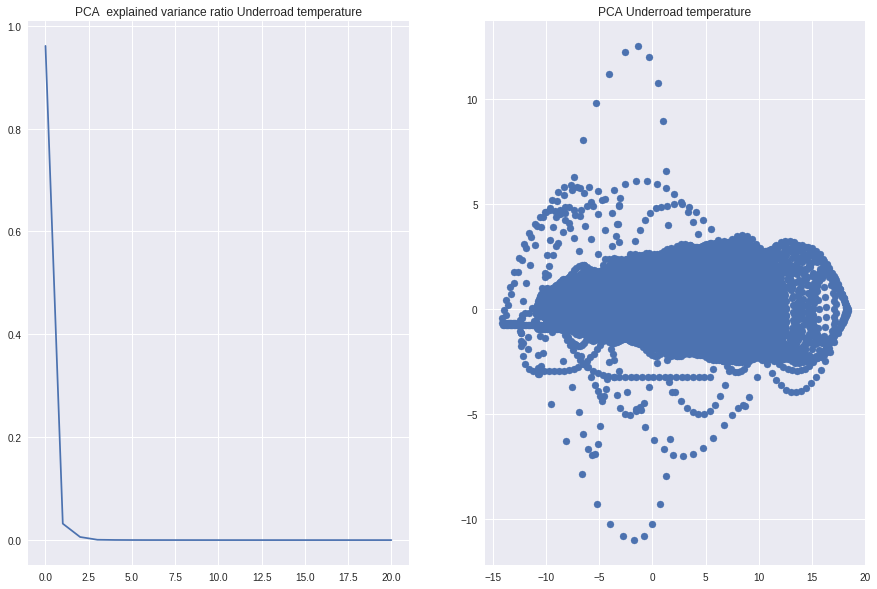

Analysis for Pressure


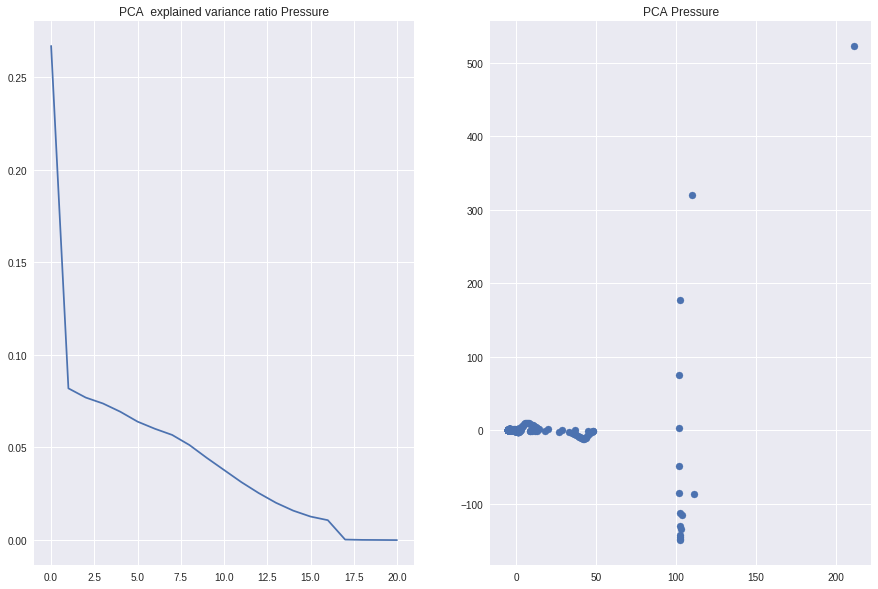

In [9]:
params_analysis('data_dampness', "Dampness")
params_analysis('data_t_air', "Air temperature")
params_analysis('data_t_road', "Road temperature")
params_analysis('data_t_underroad', "Underroad temperature")
params_analysis('data_pressure', "Pressure")

In [10]:
df = final['data_pressure']

scaler = StandardScaler().fit(df)
X_scaled_pr = scaler.transform(df)
pca_all = PCA()
pca_all.fit(X_scaled_pr)
pca = PCA(n_components= 2)
X_pca_pr = pca.fit_transform(X_scaled_pr)


itemindex = np.where(X_pca_pr[:,0] > 150)
itemindex

(array([42]),)

In [11]:
df.iloc[42]

lag
-6.0    7.477774e+03
-5.5    7.474754e+03
-5.0    7.471000e+03
-4.5    7.471000e+03
-4.0    7.471000e+03
-3.5    7.471000e+03
-3.0    7.467497e+03
-2.5    7.463631e+03
-2.0    7.463000e+03
-1.5    7.464977e+03
-1.0    7.467540e+03
-0.5    7.470103e+03
 0.0    7.471000e+03
 0.5    7.464902e+03
 1.0    7.463000e+03
 1.5    7.463000e+03
 2.0    7.469851e+03
 2.5    7.467579e+03
 3.0    7.463798e+03
 3.5    5.600193e+06
 4.0    2.663423e+06
Name: 42, dtype: float64

In [12]:
df = final['data_pressure']
df.iloc[42:58]

lag,-6.0,-5.5,-5.0,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,...,-0.5,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0
42,7477.773835,7474.754263,7471.000000,7471.000000,7.471000e+03,7.471000e+03,7.467497e+03,7.463631e+03,7.463000e+03,7.464977e+03,...,7.470103e+03,7.471000e+03,7.464902e+03,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06
43,7474.754263,7471.000000,7471.000000,7471.000000,7.471000e+03,7.467497e+03,7.463631e+03,7.463000e+03,7.464977e+03,7.467540e+03,...,7.471000e+03,7.464902e+03,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03
44,7471.000000,7471.000000,7471.000000,7471.000000,7.467497e+03,7.463631e+03,7.463000e+03,7.464977e+03,7.467540e+03,7.470103e+03,...,7.464902e+03,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03
45,7471.000000,7471.000000,7471.000000,7467.497181,7.463631e+03,7.463000e+03,7.464977e+03,7.467540e+03,7.470103e+03,7.471000e+03,...,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03
46,7471.000000,7471.000000,7467.497181,7463.631409,7.463000e+03,7.464977e+03,7.467540e+03,7.470103e+03,7.471000e+03,7.464902e+03,...,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03
47,7471.000000,7467.497181,7463.631409,7463.000000,7.464977e+03,7.467540e+03,7.470103e+03,7.471000e+03,7.464902e+03,7.463000e+03,...,7.469851e+03,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03,7.470279e+03
48,7467.497181,7463.631409,7463.000000,7464.976504,7.467540e+03,7.470103e+03,7.471000e+03,7.464902e+03,7.463000e+03,7.463000e+03,...,7.467579e+03,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03,7.470279e+03,7.471000e+03
49,7463.631409,7463.000000,7464.976504,7467.539694,7.470103e+03,7.471000e+03,7.464902e+03,7.463000e+03,7.463000e+03,7.469851e+03,...,7.463798e+03,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03,7.470279e+03,7.471000e+03,7.471000e+03
50,7463.000000,7464.976504,7467.539694,7470.102884,7.471000e+03,7.464902e+03,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,...,5.600193e+06,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03,7.470279e+03,7.471000e+03,7.471000e+03,7.464771e+03
51,7464.976504,7467.539694,7470.102884,7471.000000,7.464902e+03,7.463000e+03,7.463000e+03,7.469851e+03,7.467579e+03,7.463798e+03,...,2.663423e+06,7.463000e+03,7.463000e+03,7.463000e+03,7.466416e+03,7.470279e+03,7.471000e+03,7.471000e+03,7.464771e+03,7.466149e+03


(337115, 21)
(337098, 21)


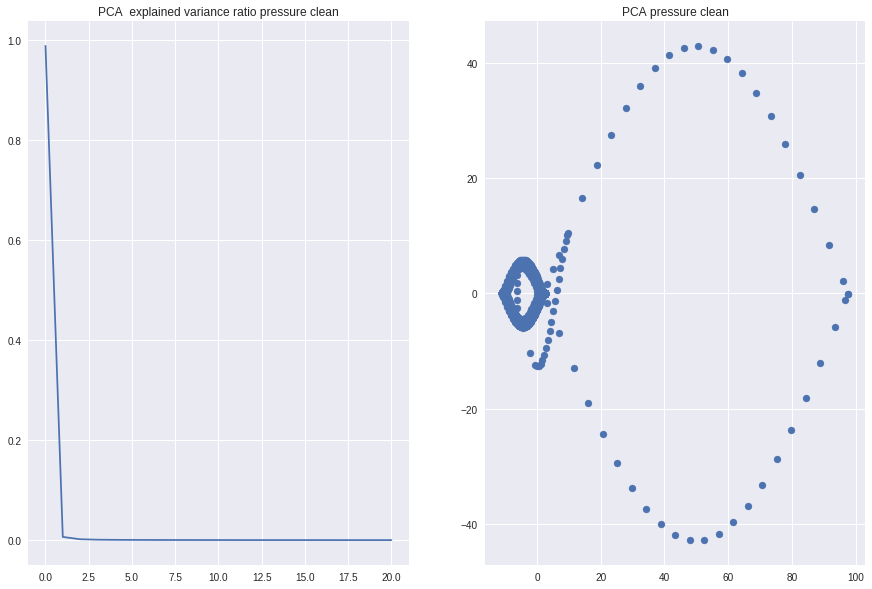

In [17]:
df = final['data_pressure']

print(df.shape)

pressure_clean = df.drop(df.index[range(42,59)])
print(pressure_clean.shape)

scaler = StandardScaler().fit(pressure_clean)
X_scaled_pr = scaler.transform(pressure_clean)
pca_all = PCA()
pca_all.fit(X_scaled_pr)
pca = PCA(n_components= 2)
X_pca_pr = pca.fit_transform(X_scaled_pr)

title = "pressure clean"

f, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(15,10))
        
ax1.plot(pca_all.explained_variance_ratio_)
ax1.set_title("PCA  explained variance ratio " + title) 


ax2.scatter(X_pca_pr[:, 0], X_pca_pr[:, 1])
# ax2.set_xlim(right = 5)
ax2.set_title("PCA " + title)


plt.show()

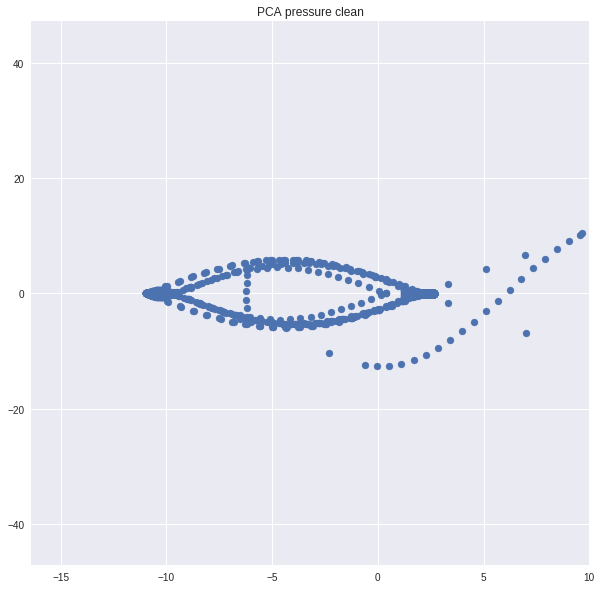

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(X_pca_pr[:, 0], X_pca_pr[:, 1])
plt.xlim(right = 10)
plt.title("PCA " + title)


plt.show()

In [14]:
itemindex = np.where(X_pca_pr[:,0] > 5)
itemindex

(array([321956, 321957, 321958, 321959, 321960, 321961, 321962, 321963,
        321964, 321965, 323350, 323351, 323352, 323353, 323354, 323355,
        323356, 323357, 323358, 323359, 323360, 323361, 323362, 323363,
        323364, 323365, 323366, 323367, 323368, 323369, 323370, 323371,
        323372, 323373, 323374, 323375, 323376, 323377, 323378, 323379,
        323380, 323381, 323382, 323383, 323384, 323385, 323386, 323387,
        323388, 323389, 323390, 323391, 323392, 323393]),)

In [15]:
first_ind = np.array(itemindex)[0][0 : 10]

In [16]:
pressure_clean.iloc[range(321956, 321970)]

lag,-6.0,-5.5,-5.0,-4.5,-4.0,-3.5,-3.0,-2.5,-2.0,-1.5,...,-0.5,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0
321973,7510.000000,7510.000000,7513.820781,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,...,7520.000000,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839
321974,7510.000000,7513.820781,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,...,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853
321975,7513.820781,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,...,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000
321976,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,...,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000
321977,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,...,7522.302198,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000
321978,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,...,7530.000000,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000
321979,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7522.302198,...,7530.000000,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000,740.000000
321980,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,...,7530.000000,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
321981,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,...,20946.069803,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
321982,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7520.000000,7522.302198,7530.000000,7530.000000,7530.000000,...,51360.333839,39159.803853,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
